In [12]:
from transformers import AutoImageProcessor, AutoModel
import torch
import torch.functional as F
from torch.utils.data import DataLoader
from src.model import SiameseDino
from src.train import evaluate
from src.data import CachedCollection, LazyLoadCollection, create_dataset_splits, make_transform
from pathlib import Path
import chromadb
import numpy as np
from PIL import Image

In [2]:
base_model_name = "facebook/dinov3-vitb16-pretrain-lvd1689m"
processor = AutoImageProcessor.from_pretrained(base_model_name)
dinov3_model = AutoModel.from_pretrained(
    base_model_name,
    dtype=torch.float32
)

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

In [42]:
hidden_dim = 512
output_dim = 128
device = torch.device("cuda" if torch.backends.mps.is_available() else "cpu")
siamese_model = SiameseDino(dinov3_model, hidden_dim, output_dim)
siamese_model.load_state_dict(torch.load("../model_checkpoints/misunderstood-thunder-165.pth"))
_ = siamese_model.to(device)

In [4]:
original_root_path = Path("../data/original_data")
augmented_root_path = Path("../data/augmented_data16")
splits = create_dataset_splits(original_root_path, augmented_root_path, 0, 1, 1)

Found 102 total classes.
Splitting classes: 1 Train / 101 Val / 0 Test

Processing Train classes...
Processing Validation classes...
Processing Test classes...

--- Data Split Summary ---
Training Loader:      16 samples from 1 classes (Augmented)
Gallery Loader:      307 samples from 102 classes (Original)
Val Query Loader:    101 samples from 101 classes (Original)
Test Query Loader:     0 samples from 0 classes (Original)


In [5]:
gallery = CachedCollection(splits["gallery"][0], splits["gallery"][1], make_transform())
queries = CachedCollection(splits["val_query"][0], splits["val_query"][1], make_transform())
gallery_dataloader = DataLoader(gallery, batch_size=32)
queries_dataloader = DataLoader(queries, batch_size=32)

In [43]:
@torch.no_grad()
def compute_all_embeddings(gallery_dataloader, processor, model) -> np.ndarray:
    all_embeddings = []
    all_paths = []
    for i, (images, _) in enumerate(gallery_dataloader):
        inputs = processor(images=images, return_tensors="pt").to(model.device)
        emb = model(**inputs)
        if not model.normalize:
            emb = F.normalize(emb, p=2, dim=1)  # normalize
        all_embeddings.append(emb.cpu())
        all_paths.extend(gallery_dataloader.dataset.paths[i*gallery_dataloader.batch_size:(i+1)*gallery_dataloader.batch_size])
    
    return torch.cat(all_embeddings, dim=0), all_paths

embeddings, paths = compute_all_embeddings(gallery_dataloader, processor, siamese_model)

In [44]:
client = chromadb.Client()
client.delete_collection("Capsules")
collection = client.create_collection(name="Capsules")

In [45]:
collection.add(paths, embeddings.numpy())

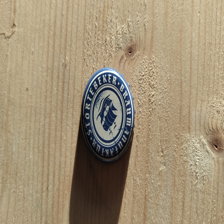

In [134]:
@torch.no_grad()
def show_closest(image: Image, collection: chromadb.Collection, processor, model):
    input = processor(images=image, return_tensors="pt").to(model.device)
    embedding = model(**input).cpu().numpy()
    res = collection.query(embedding)

    return res["ids"]

query = Image.open(queries.images_paths[48]).resize((224, 224))
query

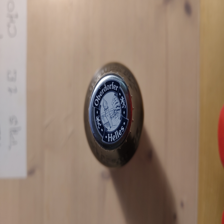

In [140]:
Image.open(show_closest(query, collection, processor, siamese_model)[0][0]).resize((224, 224))